In [1]:
import numpy as np
from matplotlib import pyplot as plt

from tqdm import tqdm

from gcv import SketchedSVDRidge, SketchedSolveRidge, EnsembleGCV, SketchedRidgeParams
from gcv.sketches import GaussianSketchFactory, OrthogonalSketchFactory, CountSketchFactory, SubsampledFourierSketchFactory, SketchSizeParams

In [2]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{bm}')
plt.rcParams['figure.figsize'] = [6, 2]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 'small'
plt.rcParams['axes.titlepad'] = 3
plt.rcParams['xtick.labelsize'] = 'x-small'
plt.rcParams['ytick.labelsize'] = plt.rcParams['xtick.labelsize']
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['legend.handlelength'] = 1.5
plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.7
plt.rcParams['patch.linewidth'] = 0.7
plt.rcParams['hatch.linewidth'] = 0.7
plt.rcParams['axes.linewidth'] = 0.6
plt.rcParams['grid.linewidth'] = 0.6
plt.rcParams['xtick.major.width'] = 0.6
plt.rcParams['xtick.minor.width'] = 0.4
plt.rcParams['ytick.major.width'] = plt.rcParams['xtick.major.width']
plt.rcParams['ytick.minor.width'] = plt.rcParams['xtick.minor.width']

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
marker_cycle = ['o', 's', 'v', 'D', 'P', 'X', '*']

In [3]:
n, p = 500, 600
sigma = 1
rng = np.random.default_rng(42)
n_trials = 100
n_ens = 5

In [4]:
# determine allowed countsketch sizes

csf = CountSketchFactory(p, rng=rng)
countsketch_sizes = []
q = p
while q > 0:
    q_ = csf(SketchSizeParams(q)).shape[0]
    if q_ > q:
        break
    countsketch_sizes.append(q_)
    q = q_ - 1

countsketch_sizes = np.asarray(countsketch_sizes[::-1])
countsketch_sizes


array([ 63, 126, 189, 252, 315, 378, 441, 504, 567])

In [5]:
q = 441
lamdas = np.logspace(-4, 2, 100)
params_path_lamda = [SketchedRidgeParams(lamda, SketchSizeParams(q)) for lamda in lamdas]

sketch_names = ['Gaussian', 'Orthogonal', 'CountSketch', 'SRDCT']
sketch_factories = [GaussianSketchFactory(p, rng=rng), OrthogonalSketchFactory(p, rng=rng), CountSketchFactory(p, rng=rng), SubsampledFourierSketchFactory(p, transform='dct', rng=rng)]

gcv_errors_by_lamda = np.zeros((len(sketch_names), len(params_path_lamda), n_trials))
gen_errors_by_lamda = np.zeros((len(sketch_names), len(params_path_lamda), n_trials))
test_errors_by_lamda = np.zeros((len(sketch_names), len(params_path_lamda), n_trials))

gcv_errors_ridge = np.zeros((len(params_path_lamda), n_trials))
gen_errors_ridge = np.zeros((len(params_path_lamda), n_trials))
test_errors_ridge = np.zeros((len(params_path_lamda), n_trials))

for j in tqdm(range(n_trials)):

    X = rng.normal(size=(n, p))
    beta = rng.normal(scale=1 / np.sqrt(p), size=p)
    y = X @ beta + rng.normal(scale=sigma, size=n)

    X2 = rng.normal(size=(n, p))
    y2 = X2 @ beta + rng.normal(scale=sigma, size=n)

    ridge = SketchedSVDRidge(X, y)
    ens_ridge = EnsembleGCV([ridge])

    gcv_errors_ridge[:, j] = ens_ridge.eval_gcv_path(params_path_lamda)
    gen_errors_ridge[:, j] = ens_ridge.eval_cond_gen_path(np.eye(p), beta, sigma, params_path_lamda)
    test_errors_ridge[:, j] = ens_ridge.eval_test_path(X2, y2, params_path_lamda)

    for i, (sketch, sketch_factory) in enumerate(zip(sketch_names, sketch_factories)):

        ridges = [SketchedSVDRidge(X, y, sketch_factory=sketch_factory) for _ in range(n_ens)]
        ens = EnsembleGCV(ridges)

        gcv_errors_by_lamda[i, :, j] = ens.eval_gcv_path(params_path_lamda)
        gen_errors_by_lamda[i, :, j] = ens.eval_cond_gen_path(np.eye(p), beta, sigma, params_path_lamda)
        test_errors_by_lamda[i, :, j] = ens.eval_test_path(X2, y2, params_path_lamda)

100%|██████████| 100/100 [04:47<00:00,  2.88s/it]


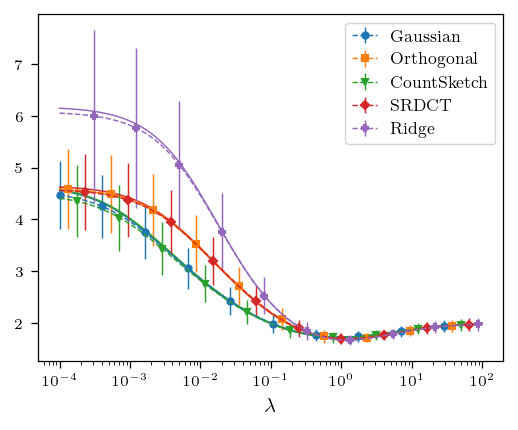

In [6]:
plt.figure(figsize=(4, 3))

for i, sketch in enumerate(sketch_names):
    markevery = (2 * i, (len(sketch_names) + 1) * 2)
    plt.plot(lamdas, gen_errors_by_lamda[i].mean(axis=1), color=color_cycle[i])
    plt.errorbar(lamdas, gcv_errors_by_lamda[i].mean(axis=1), yerr=gcv_errors_by_lamda[i].std(axis=1), color=color_cycle[i], errorevery=markevery, markevery=markevery, marker=marker_cycle[i], linestyle='--', label=sketch)

markevery = (2 * len(sketch_names), (len(sketch_names) + 1) * 2)
plt.plot(lamdas, gen_errors_ridge.mean(axis=1), color=color_cycle[len(sketch_names)])
plt.errorbar(lamdas, gcv_errors_ridge.mean(axis=1), yerr=gcv_errors_ridge.std(axis=1), color=color_cycle[len(sketch_names)], errorevery=markevery, markevery=markevery, marker=marker_cycle[len(sketch_names)], linestyle='--', label='Ridge')

plt.xscale('log')
plt.xlabel(r'$\lambda$')
plt.legend()

In [7]:
# profile
import cProfile

lamda = 0.2
qs = countsketch_sizes

with cProfile.Profile() as pr:

    params_path_q = [SketchedRidgeParams(lamda, SketchSizeParams(q)) for q in qs]

    gcv_errors_by_q = np.zeros((len(sketch_names), len(params_path_q), n_trials))
    gen_errors_by_q = np.zeros((len(sketch_names), len(params_path_q), n_trials))
    test_errors_by_q = np.zeros((len(sketch_names), len(params_path_q), n_trials))

    for j in tqdm(range(n_trials)):

        X = rng.normal(size=(n, p))
        beta = rng.normal(scale=1 / np.sqrt(p), size=p)
        y = X @ beta + rng.normal(scale=sigma, size=n)

        X2 = rng.normal(size=(n, p))
        y2 = X2 @ beta + rng.normal(scale=sigma, size=n)

        for i, sketch_factory in enumerate(sketch_factories):

            # ridges = [SketchedSVDRidge(X, y, sketch_factory=sketch_factory) for _ in range(n_ens)]
            ridges = [SketchedSolveRidge(X, y, sketch_factory=sketch_factory) for _ in range(n_ens)]
            ens = EnsembleGCV(ridges)

            for k, params in enumerate(params_path_q):

                gcv_errors_by_q[i, k, j] = ens.eval_gcv(params)
                gen_errors_by_q[i, k, j] = ens.eval_cond_gen(np.eye(p), beta, sigma, params)
                test_errors_by_q[i, k, j] = ens.eval_test(X2, y2, params)
    
    pr.print_stats(sort='tottime')

100%|██████████| 100/100 [06:21<00:00,  3.82s/it]

         11469784 function calls (11422984 primitive calls) in 381.566 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    18000  158.946    0.009  159.335    0.009 linalg.py:1084(eigvalsh)
    13500   35.222    0.003   61.620    0.005 sketches.py:107(_matmat)
    54000   29.255    0.001  341.131    0.006 gcv.py:301(update_sketch)
     9500   29.245    0.003   29.245    0.003 {method 'normal' of 'numpy.random._generator.Generator' objects}
    18000   28.985    0.002   29.213    0.002 linalg.py:313(solve)
     9000   25.081    0.003   25.081    0.003 {built-in method scipy.sparse._sparsetools.csc_matvecs}
     9000   20.438    0.002   20.438    0.002 {built-in method numpy.linalg.lapack_lite.dorgqr}
     9000   16.957    0.002   16.957    0.002 {built-in method numpy.linalg.lapack_lite.dgeqrf}
     9000    5.192    0.001    5.192    0.001 {built-in method scipy.fft._pocketfft.pypocketfft.dct}
    61200    2.673    0.000    

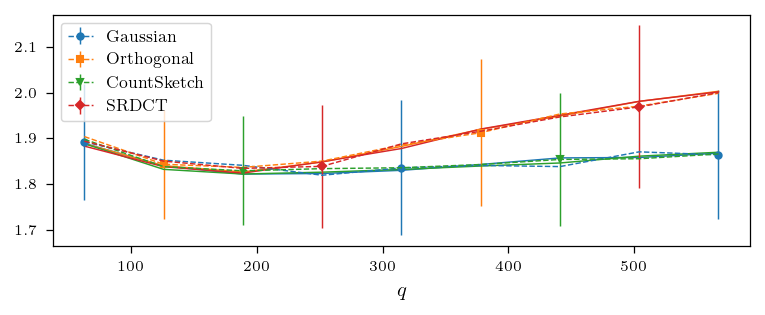

In [8]:
for i, sketch in enumerate(sketch_names):
    markevery = (i, len(sketch_names))
    plt.plot(qs, gen_errors_by_q[i].mean(axis=1), color=color_cycle[i])
    plt.errorbar(qs, gcv_errors_by_q[i].mean(axis=1), yerr=gcv_errors_by_q[i].std(axis=1), color=color_cycle[i], errorevery=markevery, markevery=markevery, marker=marker_cycle[i], linestyle='--', label=sketch)

plt.xlabel('$q$')
plt.legend()
plt.show()

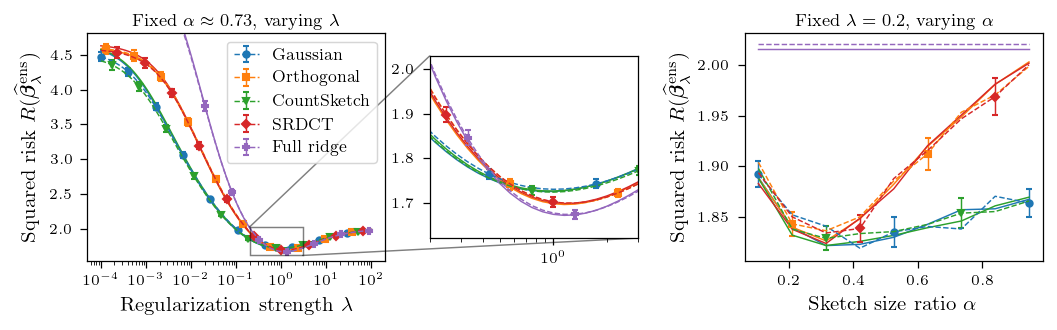

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(5.5, 2.3))
capsize = 1.5

norm = np.sqrt(n_trials)

for i, sketch in enumerate(sketch_names):

    markevery = (2 * i, 2 * (len(sketch_names) + 1))
    axes[0].plot(lamdas, gen_errors_by_lamda[i].mean(axis=1), color=color_cycle[i])
    axes[0].errorbar(lamdas, gcv_errors_by_lamda[i].mean(axis=1), yerr=gcv_errors_by_lamda[i].std(axis=1) / norm, color=color_cycle[i], errorevery=markevery, markevery=markevery, marker=marker_cycle[i], linestyle='--', label=sketch, capsize=capsize)

    markevery = (i, len(sketch_names))
    axes[1].plot(qs / p, gen_errors_by_q[i].mean(axis=1), color=color_cycle[i])
    axes[1].errorbar(qs / p, gcv_errors_by_q[i].mean(axis=1), yerr=gcv_errors_by_q[i].std(axis=1) / norm, color=color_cycle[i], errorevery=markevery, markevery=markevery, marker=marker_cycle[i], linestyle='--', label=sketch, capsize=capsize)

ylim = axes[0].get_ylim()
axes[0].plot(lamdas, gen_errors_ridge.mean(axis=1), color=color_cycle[len(sketch_names)])
markevery = (2 * len(sketch_names), 2 * (len(sketch_names) + 1))
axes[0].errorbar(lamdas, gcv_errors_ridge.mean(axis=1), yerr=gcv_errors_ridge.std(axis=1) / norm, color=color_cycle[len(sketch_names)], errorevery=markevery, markevery=markevery, marker=marker_cycle[len(sketch_names)], linestyle='--', label='Full ridge', capsize=capsize)
axes[0].set_ylim(ylim)

axes[0].set_title(f'Fixed $\\alpha \\approx {q / p:.2f}$, varying $\\lambda$')
axes[0].legend()
axes[0].set_xlabel(r'Regularization strength $\lambda$')
axes[0].set_ylabel(r'Squared risk $R(\widehat{\bm \beta}^\mathrm{ens}_\lambda)$')
axes[0].set_xscale('log')

xlim = axes[0].get_xlim()
# set major ticks
xticks = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
axes[0].set_xticks(xticks)
# set minor ticks
minor_xticks = np.concatenate(np.arange(1, 10)[:, None] * np.asarray(xticks)[None, :])
axes[0].set_xticks(minor_xticks, minor=True)
axes[0].set_xlim(xlim)


# interp to find ridge
ridge_interp_gcv = np.interp(lamda, lamdas, gcv_errors_ridge.mean(axis=1))
ridge_interp_gcv_std = np.interp(lamda, lamdas, gcv_errors_ridge.std(axis=1) / norm)
ridge_interp_gen = np.interp(lamda, lamdas, gen_errors_ridge.mean(axis=1))
axes[1].plot(qs / p, np.ones_like(qs) * ridge_interp_gcv, color=color_cycle[len(sketch_names)], linestyle='--')
axes[1].plot(qs / p, np.ones_like(qs) * ridge_interp_gen, color=color_cycle[len(sketch_names)])

axes[1].set_title(f'Fixed $\\lambda={lamda}$, varying $\\alpha$')
axes[1].set_ylabel(r'Squared risk $R(\widehat{\bm \beta}^\mathrm{ens}_\lambda)$')
axes[1].set_xlabel(r'Sketch size ratio $\alpha$')

plt.tight_layout()

# add zoomed inset to first plot
axins = axes[0].inset_axes([1.15, 0.1, 0.7, 0.8])

for i, sketch in enumerate(sketch_names):

    markevery = (2 * i, 2 * (len(sketch_names) + 1))
    axins.plot(lamdas, gen_errors_by_lamda[i].mean(axis=1), color=color_cycle[i])
    axins.errorbar(lamdas, gcv_errors_by_lamda[i].mean(axis=1), yerr=gcv_errors_by_lamda[i].std(axis=1) / norm, color=color_cycle[i], errorevery=markevery, markevery=markevery, marker=marker_cycle[i], linestyle='--', capsize=capsize)

axins.plot(lamdas, gen_errors_ridge.mean(axis=1), color=color_cycle[len(sketch_names)])
markevery = (2 * len(sketch_names), 2 * (len(sketch_names) + 1))
axins.errorbar(lamdas, gcv_errors_ridge.mean(axis=1), yerr=gcv_errors_ridge.std(axis=1) / norm, color=color_cycle[len(sketch_names)], errorevery=markevery, markevery=markevery, marker=marker_cycle[len(sketch_names)], linestyle='--', capsize=capsize)

axins.set_xscale('log')
axins.set_xlim(0.2, 3)
axins.set_ylim(1.62, 2.03)
axes[0].indicate_inset_zoom(axins, edgecolor='black')

right_adjust = 0.30

# move inset plot to right
pos = axins.get_position()
pos.x0 += right_adjust
pos.x1 += right_adjust
axins.set_position(pos)

# move second plot to right
pos = axes[1].get_position()
pos.x0 += right_adjust
pos.x1 += right_adjust
axes[1].set_position(pos)

plt.savefig('figures/gcv_paths.pdf', bbox_inches='tight')
plt.show()

Bbox([[0.7591889135526764, 0.20445285609736064], [1.1769230769230767, 0.8913160993766864]])